# Ingredient Image Analysis

The focus of this analysis lies on the OpenFoodFacts products which have associated ingredient images.

Data used: jsonl.gz dataset from March 17 2025.

## Insights Summary

1,017,429 products have ingredient image(s) - which is ~27.7% of all products

### Tags assigned to products

Products have state_tags and data_quality_tags that usually correlate with other fields. However, they not fully aligned.

- 961,041 products with ingredient image(s) (94.5%) have state tag `en:ingredients-photo-selected` -> 56,398 (5.5%) missing. 🤔
- 639,044 products with ingredient image(s) (62.2%) have identified ingredients (known, unknown) -> 378,385 products (37.7%) have not been analyzed. 🤔
- 639,133 products (62.3%) have field `ingredients_percent_analysis`
- 568,873 products (55.5%) have `ingredients_percent_analysis` = 1
- 568,282 products (??) have data_quality_tag `en:ingredients-percent-analysis-ok`

### Number of ingredient images per product

- 895,262 products (88.0%) have one ingredient image.
- 108,168 products (10.6%) have two ingredient images.
-  14,009 products ( 1.4%) have three or more ingredient images.

### Languages of ingredient images

- 579,762 (57.0%) fr 🇫🇷
- 212,462 (20.9%) en 🇬🇧🇺🇸
- 107,551 (10.6%) de 🇩🇪
-  78,250 ( 7.7%) es 🇪🇸
-  46,234 ( 4.5%) no lc ❓🤔
- 139,042 (13.7%) in 111 other languages 🌎

### Open Questions:
- OCR
    - how many photos have extracted text?
    - are extractions missing for some languages?
    - what is the reported extraction error from Google Vision?
- Ingredient Recognition
    - What are the most unrecognized ingredients per image?
    - What is the main reason for these errors? (OCR, spelling, missing taxonomy?)

## Download jsonl.gz snapshot

This will take a couple of minutes

In [1]:
%%time
%%bash
if [ ! -f "openfoodfacts-products.jsonl.gz" ]; then
    curl -L -O https://static.openfoodfacts.org/data/openfoodfacts-products.jsonl.gz;
else
    echo "file already exists. skipping download";
fi

file already exists. skipping download
CPU times: user 2.34 ms, sys: 5.77 ms, total: 8.11 ms
Wall time: 7.51 ms


## Data Extraction

Extract relevant fields related to ingredients and ingredient images.

This is done with `jq` which is well suited for processing json data. An alternative is duckdb - it is faster but has issues, like unexpected characters and duplicates when dealing with gz files.

This can take 15-20 minutes.

In [2]:
%%time
%%bash
if [ ! -f "ingredients_data_export_jq.csv.gz" ]; then
  (
  echo "code,ingredients_n,known_ingredients_n,unknown_ingredients_n,has_analysis_tags,ingredients_percent_analysis,ingredients_text,images,states,quality_info"
  zcat < openfoodfacts-products.jsonl.gz | jq -r '
  (.images // {}) as $img |
  ($img | to_entries | map(select(.key | startswith("ingred"))) ) as $ingimg |
  def resolve(field):
    if .value.imgid == null then null else $img[ (.value.imgid | tostring) ][field] end;
  def subset(prefix):
    map(select(startswith(prefix))) | if length > 0 then join(",") else null end;
  [
    .code,
    (if .ingredients_n == null then null else (.ingredients_n | tonumber) end),
    (if .known_ingredients_n == null then null else (.known_ingredients_n | tonumber) end),
    (if .unknown_ingredients_n == null then null else (.unknown_ingredients_n | tonumber) end),
    (if .ingredients_analysis_tags != null then true else false end),
    .ingredients_percent_analysis,
    .ingredients_text,
    ($ingimg
      | map({ key: .key, value: { imgid: .value.imgid, uploader: resolve("uploader"), uploaded_t: resolve("uploaded_t") } })
      | from_entries
      | if length > 0 then tojson else null end
    ),
    (.states_tags // [] | subset("en:ingred")),
    (.data_quality_info_tags // [] | subset("en:ingred"))
  ]
  | @csv'
  ) | gzip -9 >ingredients_data_export_jq.csv.gz
else
  echo "file already exists. skipping processing";
fi

file already exists. skipping processing
CPU times: user 1.72 ms, sys: 4.69 ms, total: 6.41 ms
Wall time: 6.83 ms


## Data Loading

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from dateutil.relativedelta import relativedelta

In [4]:
%%time
file_path = "./ingredients_data_export_jq.csv.gz"
df = pd.read_csv(file_path, dtype={'code':str})
df = df[df.code.notna()].set_index('code') # exclude empty barcodes

# use Int64 for counts with NaN
for col in ['ingredients_n', 'known_ingredients_n', 'unknown_ingredients_n', 'ingredients_percent_analysis']:
    df[col] = df[col].astype('Int64')

# convert json string to dict
df.images = df.images.fillna('null').map(json.loads)

display(df)

,ingredients_n,known_ingredients_n,unknown_ingredients_n,has_analysis_tags,ingredients_percent_analysis,ingredients_text,images,states,quality_info
code,,,,,,,,,
0000101209159,<NA>,<NA>,<NA>,False,<NA>,NaN,"{'ingredients_fr': {'imgid': '2', 'uploader': ...","en:ingredients-to-be-completed,en:ingredients-...",NaN
0000105000011,1,3,0,True,1,CHAMOMILE FLOWERS.,None,en:ingredients-completed,en:ingredients-percent-analysis-ok
0000105000042,1,3,0,True,1,Peppermint.,None,en:ingredients-completed,en:ingredients-percent-analysis-ok
0000105000059,1,0,1,True,1,LINDEN FLOWERS.,None,en:ingredients-completed,en:ingredients-percent-analysis-ok
0000105000073,1,2,0,True,1,Hibiscus flowers.,None,en:ingredients-completed,en:ingredients-percent-analysis-ok
...,...,...,...,...,...,...,...,...,...
8718907242424,<NA>,<NA>,<NA>,False,<NA>,NaN,None,en:ingredients-to-be-completed,NaN
0007405956277,<NA>,<NA>,<NA>,False,<NA>,NaN,None,"en:ingredients-to-be-completed,en:ingredients-...",NaN
3760019590615,<NA>,<NA>,<NA>,False,<NA>,NaN,None,"en:ingredients-to-be-completed,en:ingredients-...",NaN


CPU times: user 12.3 s, sys: 1.05 s, total: 13.3 s
Wall time: 13.8 s


### Check Duplicate Barcodes

Unfortunately, the dataset contains some duplicate barcodes. However, the data is different and seems to be from different updates/edits.

This would need further investigation but is ignored right now.

In [5]:
df.loc[lambda x: x.index.value_counts() > 1].sort_index()

,ingredients_n,known_ingredients_n,unknown_ingredients_n,has_analysis_tags,ingredients_percent_analysis,ingredients_text,images,states,quality_info
code,,,,,,,,,
0059527070430,24,34,4,True,-1,"Raisins* (20%) (raisins*, huile de tournesol*)...","{'ingredients_fr': {'imgid': '4', 'uploader': ...","en:ingredients-completed,en:ingredients-photo-...",NaN
0059527070430,21,36,0,True,1,"Raisins secs*(20%)(raisins secs*, huile de tou...","{'ingredients_fr': {'imgid': '3', 'uploader': ...","en:ingredients-completed,en:ingredients-photo-...",en:ingredients-percent-analysis-ok
0059527171687,24,28,6,True,-1,"CASHEWS (14%) AGAVE SYRUP*, ROASTED PEANUTS* (...","{'ingredients_en': {'imgid': '1', 'uploader': ...","en:ingredients-completed,en:ingredients-photo-...",NaN
0059527171687,24,40,1,True,1,"Noix de cajou* (15%), sirop d’agave*, arachide...","{'ingredients_fr': {'imgid': '4', 'uploader': ...","en:ingredients-completed,en:ingredients-photo-...",en:ingredients-percent-analysis-ok
0059527401555,<NA>,<NA>,<NA>,False,<NA>,NaN,"{'ingredients_fr': {'imgid': '5', 'uploader': ...","en:ingredients-to-be-completed,en:ingredients-...",NaN
...,...,...,...,...,...,...,...,...,...
8722700628927,13,21,2,True,1,Gelato alla panna. Ingredienti: LATTE Scremato...,"{'ingredients_it': {'imgid': '1', 'uploader': ...","en:ingredients-completed,en:ingredients-photo-...",en:ingredients-percent-analysis-ok
915024285012997,<NA>,<NA>,<NA>,False,<NA>,NaN,None,"en:ingredients-to-be-completed,en:ingredients-...",NaN
915024285012997,<NA>,<NA>,<NA>,False,<NA>,NaN,None,"en:ingredients-to-be-completed,en:ingredients-...",NaN


In [6]:
# helper function for charts

def annotate_hbars(ax, total: int):
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 1, p.get_y() + p.get_height() / 2,
            f' {width:,}\n ({width / total * 100:.1f}%)', va='center', ha='left', fontsize=8)

## Part I: Analyze Ingredient Images

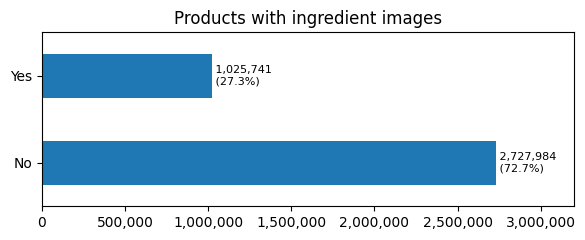

In [7]:
has_image = df.images.notna()
ax = has_image.value_counts().plot.barh(figsize=(6,2.5))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.set_ylabel(None)
ax.set_yticklabels(['No', 'Yes'])

annotate_hbars(ax, len(df))
plt.xlim(0, 3.2e6)

plt.title('Products with ingredient images')
plt.tight_layout()
plt.show()

In [8]:
# create subset of products with images
df_images = df[has_image]

## Check coverage of `en:ingredients-photo-selected`

The states tag `en:ingredients-photo-selected` should get set when an ingredient images is selected. Let's see if this correlates with what we find in the images object.

In [9]:
print("selected total:", df.states.str.contains('en:ingredients-photo-selected').sum())
print("selected images:", df_images.states.str.contains('en:ingredients-photo-selected').sum())
print("images total:", len(df_images))
print("selected images diff:", "{:,}".format(len(df_images) - df.states.str.contains('en:ingredients-photo-selected').sum()))
print("selected images percent:", "{:.1f}%".format(df.states.str.contains('en:ingredients-photo-selected').sum() / len(df_images) * 100))

selected total: 968681
selected images: 968681
images total: 1025741
selected images diff: 57,060
selected images percent: 94.4%


## Number of Ingredient Images per Product

Ingredient images can be selected for multiple languages. Let's check the distribution.

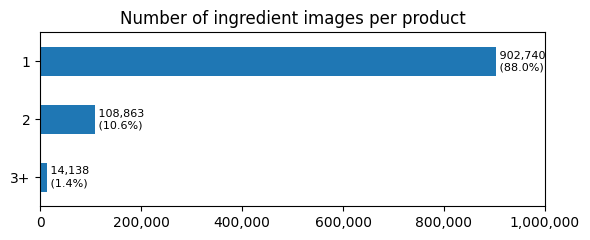

In [10]:
img_counts = df_images.images.map(len).map(lambda x: "3+" if x >= 3 else str(x))

ax = img_counts.value_counts().sort_index(ascending=False).plot.barh(figsize=(6,2.5))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.set_ylabel(None)
ax.set_xlim(0, 1e6)

annotate_hbars(ax, len(df_images))
    
plt.title('Number of ingredient images per product')
plt.tight_layout()
plt.show()

### What are the most frequent languages of ingredient images?

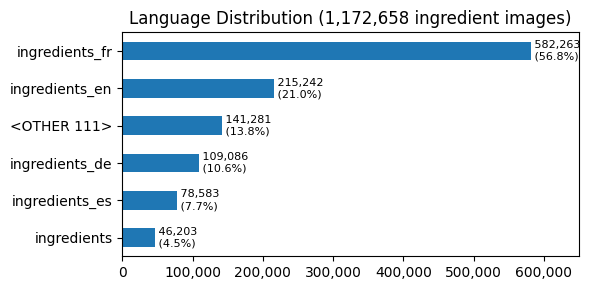

In [11]:
max_count = 5
img_lang = df_images.images.map(dict.keys).explode()
top_langs = img_lang.value_counts().head(max_count).index
other_count= len(img_lang.value_counts())-max_count
lang_values = img_lang.map(lambda x: x if x in top_langs else f"<OTHER {other_count}>").value_counts()

ax = lang_values.plot.barh(figsize=(6,3))
ax.invert_yaxis()

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.set_ylabel(None)
ax.set_xlim(0, 650000)

annotate_hbars(ax, len(df_images))
    
plt.title(f'Language Distribution ({len(img_lang):,} ingredient images)')
plt.tight_layout()
plt.show()

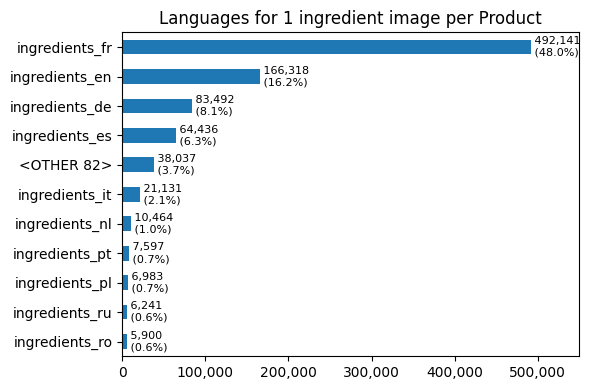

In [12]:
img_lang1 = df_images.images[img_counts == '1'].map(dict.keys).explode()
top_langs1 = img_lang1.value_counts().head(10).index
other_count= len(img_lang1.value_counts())-10

ax = img_lang1.map(lambda x: x if x in top_langs1 else f"<OTHER {other_count}>").value_counts().plot.barh(figsize=(6,4))
ax.invert_yaxis()

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.set_ylabel(None)
ax.set_xlim(0, 550000)

annotate_hbars(ax, len(df_images))

plt.title('Languages for 1 ingredient image per Product', )
plt.tight_layout()
plt.show()

### Language Co-occurrence

In [13]:
import itertools

img_lang2 = df_images.images.map(dict.keys)[lambda x: x.map(len) >= 2]
langs = img_lang2.explode().value_counts().index
short_langs = langs.str.replace('ingredients', '').str.replace('_', '')

co_occurrence = pd.DataFrame(0, index=langs, columns=langs)
for lang_list in img_lang2:
    for lang1, lang2 in itertools.combinations(lang_list, 2):
        co_occurrence.loc[lang1, lang2] += 1
        co_occurrence.loc[lang2, lang1] += 1

# (Optional) Count individual language occurrences on the diagonal
for lang_list in img_lang2:
    for lang in lang_list:
        co_occurrence.loc[lang, lang] += 1

co_occurrence.columns = short_langs
co_occurrence.index = short_langs


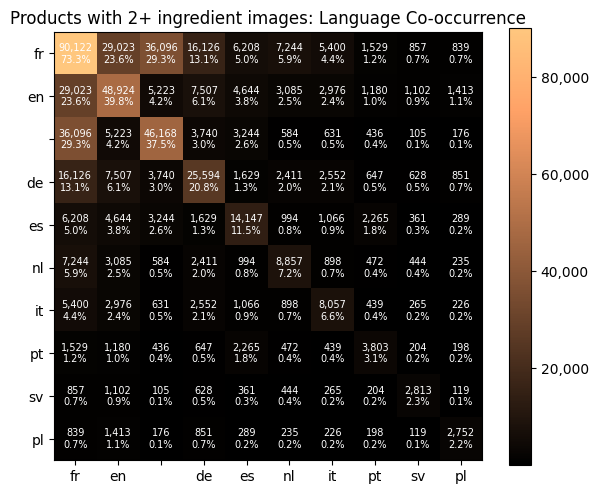

In [14]:
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(co_occurrence.iloc[:10, :10], cmap='copper', interpolation='nearest')

# Show language labels on axes
plt.xticks(range(10), short_langs[:10])
plt.yticks(range(10), short_langs[:10])

plt.colorbar(im, ax=ax, format=FuncFormatter(lambda x, pos: f'{int(x):,}'))

# Print the count in each cell
for i in range(10):
    for j in range(10):
        # The co-occurrence value at row i, column j
        value = co_occurrence.iloc[i, j]
        ax.text(j, i, f"{value:,}\n{value / len(img_lang2) * 100:.1f}%",
                ha='center', va='center', color='white', fontsize=7)

plt.title("Products with 2+ ingredient images: Language Co-occurrence")
plt.tight_layout()
plt.show()

## Known + Unknown Ingredients

In [15]:
print("Known:", "{:,}".format(df_images.known_ingredients_n.notna().sum()))
print("Unknown:", "{:,}".format(df_images.unknown_ingredients_n.notna().sum()))
print("Known+Unknown:", "{:,}".format((df_images.known_ingredients_n.notna() & df_images.unknown_ingredients_n.notna()).sum()))

df_identified = df_images[lambda x: x.known_ingredients_n.notna() & x.unknown_ingredients_n.notna()]
print("percentage products analyzed: {:.1f}%".format(len(df_identified) / len(df_images) * 100))

Known: 639,044
Unknown: 639,094
Known+Unknown: 639,044
percentage products analyzed: 62.3%


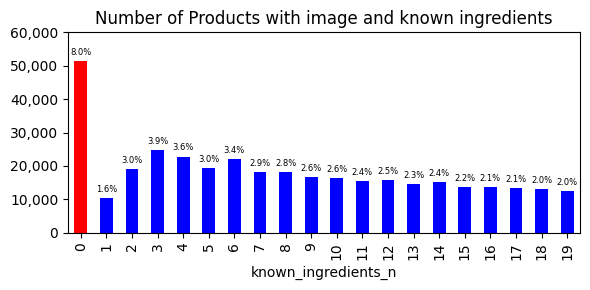

In [16]:
dfx = df_identified.known_ingredients_n.value_counts().sort_index()
colors = ['red' if idx == 0 else 'blue' for idx in dfx[:20].index]

ax = dfx[:20].plot.bar(figsize=(6,3), color=colors)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))

# Annotate each bar with its value
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height / len(df_identified) * 100:.1f}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset text slightly above the bar
                textcoords="offset points",
                ha='center', va='bottom', fontsize=6)

ax.set_ylim(0, 60000)
plt.title("Number of Products with image and known ingredients")
plt.tight_layout();

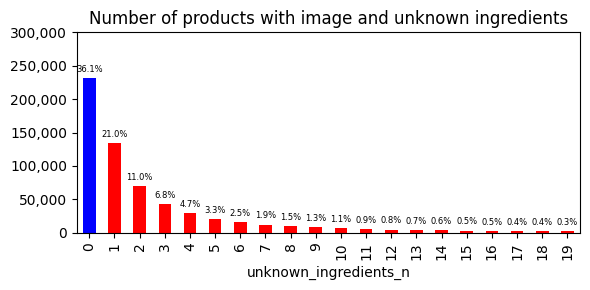

In [17]:
dfx = df_identified.unknown_ingredients_n.value_counts().sort_index()
dfx.index = pd.CategoricalIndex(dfx.index, ordered=True)
colors = ['blue' if idx == 0 else 'red' for idx in dfx[:20].index]

ax = dfx[:20].plot.bar(figsize=(6,3), color=colors)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))

# Annotate each bar with its value
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height / len(df_identified) * 100:.1f}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset text slightly above the bar
                textcoords="offset points",
                ha='center', va='bottom', fontsize=6)

ax.set_ylim(0, 300000)
plt.title("Number of products with image and unknown ingredients")
plt.tight_layout();
plt.savefig("unknown_number_ingredients.png");

### Check Co-occurrence of Known and Unknown Ingredients

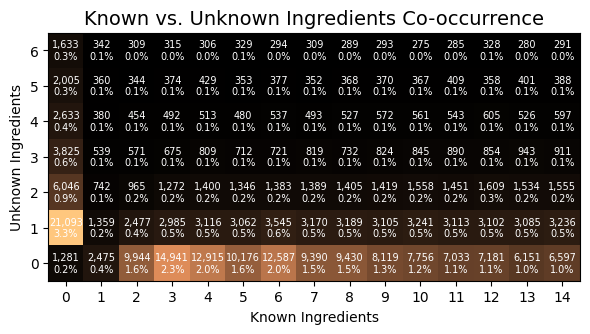

In [18]:
co_occurrence = pd.crosstab(
    df_identified.unknown_ingredients_n,
    df_identified.known_ingredients_n
)

maxx = 15
maxy = 7
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(co_occurrence.iloc[:maxy, :maxx], cmap='copper', interpolation='nearest')

# Show language labels on axes
plt.xticks(range(maxx), range(maxx))
plt.yticks(range(maxy), range(maxy))
plt.xlabel('Known Ingredients')
plt.ylabel('Unknown Ingredients')

ax.invert_yaxis()

# Print the count in each cell
for y in range(maxy):
    for x in range(maxx):
        # The co-occurrence value at row i, column j
        value = co_occurrence.iloc[y, x]
        ax.text(x, y, f"{value:,}\n{value / len(df_identified) * 100:.1f}%",
                ha='center', va='center', color='white', fontsize=7)

plt.title("Known vs. Unknown Ingredients Co-occurrence", fontsize=14)
plt.tight_layout()
plt.show()

### Compute Known Ingredients Ratio

*known / (known + unknown)*

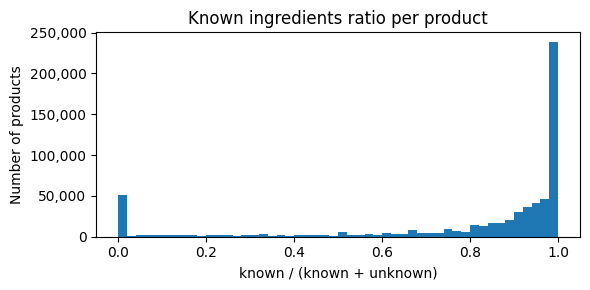

In [ ]:
# vectorized version of the ratio function
def known_ratio(df: pd.DataFrame) -> pd.Series:
    known = df.known_ingredients_n
    unknown = df.unknown_ingredients_n
    total = known + unknown
    return known.div(total).where(total != 0, 0.0).where(total.notna(), pd.NA)

df_ratio = known_ratio(df_identified)

ax = df_ratio.plot.hist(bins=50, figsize=(6,3))

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))

plt.xlabel('known / (known + unknown)')
plt.ylabel('Number of products')
plt.title('Known ingredients ratio per product')
plt.tight_layout()
plt.show()

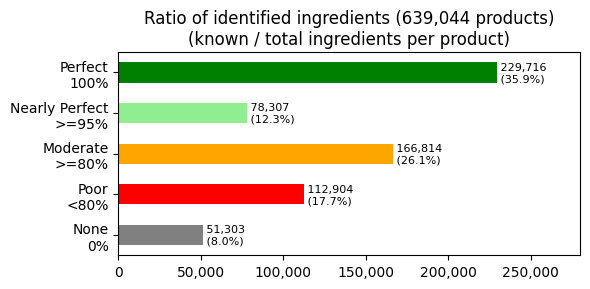

In [20]:
colors = ['green', 'lightgreen', 'orange', 'red', 'grey']
categories = ["100%", ">=95%", ">=80%", "<80%", "0%"]
labels = ['Perfect', 'Nearly Perfect', 'Moderate', 'Poor', 'None']

def categorize_ratio(ratio: float):
    if ratio is None or pd.isna(ratio):
        return "N/A"
    
    if ratio == 1:
        return categories[0]
    elif ratio >= 0.95:
        return categories[1]
    elif ratio >= 0.80:
        return categories[2]
    elif ratio == 0:
        return categories[4]
    else:
        return categories[3]

# Add the new column with the categories
s_cat_identified = df_ratio.map(categorize_ratio)
ax = s_cat_identified.value_counts().reindex(categories).plot.barh(figsize=(6,3), color=colors)

ax.yaxis.set_major_formatter(lambda x, pos: f"{labels[pos]}\n{categories[pos]}")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.invert_yaxis()
ax.set_xlim(0, 280000)

annotate_hbars(ax, len(df_identified))
    
plt.title(f"Ratio of identified ingredients ({len(df_identified):,} products)\n(known / total ingredients per product)")
plt.tight_layout()
plt.savefig("ratio_rating_ingredients.png");

### Check Ingredient Percent Analysis

In [21]:
len(df_images[lambda x: x.ingredients_percent_analysis.notna()])

639133

Text(0.5, 1.0, 'Ingredient Analysis by Ratio (1,025,741 products)')

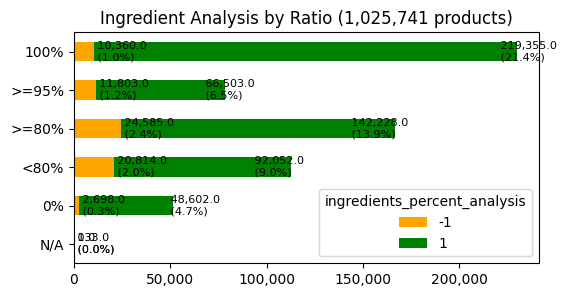

In [22]:
df_cross = pd.crosstab(
  known_ratio(df_images).map(categorize_ratio),
  df_images.ingredients_percent_analysis
).reindex(index=[*categories, "N/A"])

ax = df_cross.plot.barh(stacked=True, figsize=(6, 3), color=['orange', 'green'])
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.invert_yaxis()
ax.set_ylabel(None)

annotate_hbars(ax, len(df_images))

plt.title(f"Ingredient Analysis by Ratio ({len(df_images):,} products)")

## Analyze Ingredient Images in Detail

### Ingredient Images with null values for `uploader` or `uploaded_t`

In [23]:
df_none = df_images.images.map(lambda x: {k:x[k] for k in x.keys() if x[k]['uploader'] is None or x[k]['uploaded_t'] is None})
df_none[lambda x: x.map(len) > 0]

code
0028435398622    {'ingredients_en': {'imgid': '2', 'uploader': ...
0051500042311    {'ingredients_fr': {'imgid': '3', 'uploader': ...
0055742509427    {'ingredients_fr': {'imgid': '3', 'uploader': ...
00530361         {'ingredients_lc': {'imgid': '5', 'uploader': ...
0068400021131    {'ingredients_en': {'imgid': '4', 'uploader': ...
                                       ...                        
5711657027467    {'ingredients_da': {'imgid': '3', 'uploader': ...
4316268707374    {'ingredients_de': {'imgid': '2', 'uploader': ...
7025110210968    {'ingredients_nb': {'imgid': '3', 'uploader': ...
4061462867804    {'ingredients_en': {'imgid': '2', 'uploader': ...
4088700037270    {'ingredients_en': {'imgid': '3', 'uploader': ...
Name: images, Length: 792, dtype: object

### Remove ingredient images with null values

In [24]:
df_img_clean = df_images.images.map(lambda x: {k:x[k] for k in x.keys() if x[k]['uploader'] is not None and x[k]['uploaded_t'] is not None})[lambda x: x.map(len) > 0]
df_img_clean

code
0000101209159    {'ingredients_fr': {'imgid': '2', 'uploader': ...
0000111301201    {'ingredients_en': {'imgid': '1', 'uploader': ...
0000140323687    {'ingredients_fr': {'imgid': '2', 'uploader': ...
0000141013129    {'ingredients_fr': {'imgid': '2', 'uploader': ...
0000171812457    {'ingredients_fr': {'imgid': '2', 'uploader': ...
                                       ...                        
5712875905025    {'ingredients_da': {'imgid': '2', 'uploader': ...
5708229104138    {'ingredients_da': {'imgid': '2', 'uploader': ...
5712874520052    {'ingredients_da': {'imgid': '2', 'uploader': ...
5000159571463    {'ingredients_en': {'imgid': '2', 'uploader': ...
8010995007078    {'ingredients_it': {'imgid': 2, 'uploader': 't...
Name: images, Length: 1025187, dtype: object

### Image Uploader

In [25]:
df_uploader = df_img_clean.map(lambda x: [x[k]['uploader'] for k in x.keys()])

In [26]:
df_uploader.explode().value_counts()

images
kiliweb                       443051
openfoodfacts-contributors    102497
inf                            60289
smoothie-app                   54261
elcoco                         31859
                               ...  
ross-holloway94                    1
edtwinkle                          1
koprivaqi                          1
darmilo                            1
vikkis                             1
Name: count, Length: 52474, dtype: int64

### Upload Time

In [27]:
# Convert times stamps (as int or str) to datetime
df_dates = df_img_clean.map(lambda x: [pd.to_datetime(x[k]['uploaded_t'], unit='s') for k in x.keys()])
df_dates

/var/folders/yz/vvwzcc9178l36z8l4fc42bkm0000gn/T/ipykernel_23146/3509816450.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_dates = df_img_clean.map(lambda x: [pd.to_datetime(x[k]['uploaded_t'], unit='s') for k in x.keys()])


code
0000101209159    [2018-02-22 10:57:04]
0000111301201    [2021-09-25 23:17:16]
0000140323687    [2018-08-27 10:13:12]
0000141013129    [2018-09-01 06:06:28]
0000171812457    [2018-05-01 12:22:24]
                         ...          
5712875905025    [2025-03-16 10:01:03]
5708229104138    [2025-03-16 10:03:55]
5712874520052    [2025-03-16 10:07:15]
5000159571463    [2025-03-16 10:17:25]
8010995007078    [2025-03-16 10:26:48]
Name: images, Length: 1025187, dtype: object

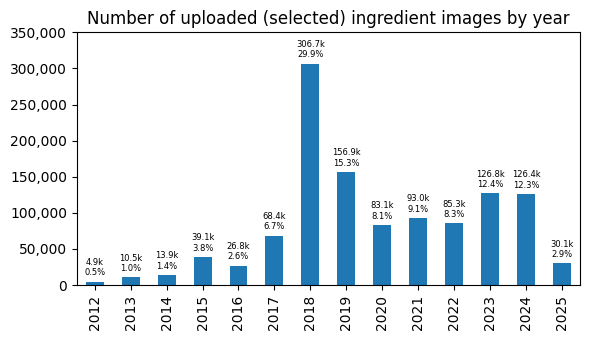

In [28]:
# explode and count the years
ax = df_dates.explode().dt.year.value_counts().sort_index().astype(int).plot.bar(figsize=(6,3.5))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))

# Annotate each bar with its value
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height / 1000:.1f}k\n{height / len(df_images) * 100:.1f}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset text slightly above the bar
                textcoords="offset points",
                ha='center', va='bottom', fontsize=6)
    
ax.set_ylim(0, 350000)

ax.set_title("Number of uploaded (selected) ingredient images by year")
ax.set_xlabel(None)

plt.tight_layout()

### Age of uploaded ingredient images (as of today)

In [29]:
df_year = df_dates.map(sorted).map(lambda x: relativedelta(pd.Timestamp.today(), x[-1]).years)

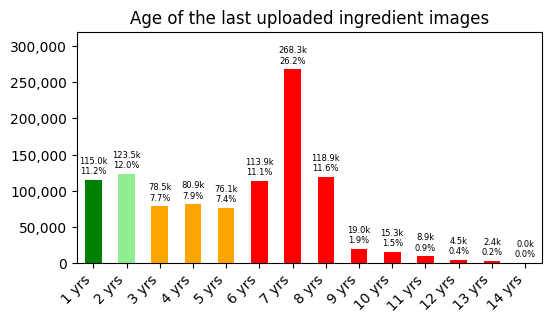

In [30]:
per_year = df_year.value_counts().sort_index()
#cumsum = df_year.value_counts().sort_index().cumsum()

colors = ['green' if idx == 0 else 'lightgreen' if idx == 1 else 'orange' if idx<5 else 'red' for idx in dfx[:20].index]

ax = per_year.plot.bar(figsize=(6,3), color=colors)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)+1} yrs'))

ax.set_xlabel(None)
#ax.set_ylabel("Cumulative count of images")
plt.xticks(rotation=45, ha='right')
plt.title("Age of the last uploaded ingredient images")
ax.set_ylim(0, 320000)

for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height / 1000:.1f}k\n{height / len(df_year) * 100:.1f}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset text slightly above the bar
                textcoords="offset points",
                ha='center', va='bottom', fontsize=6)

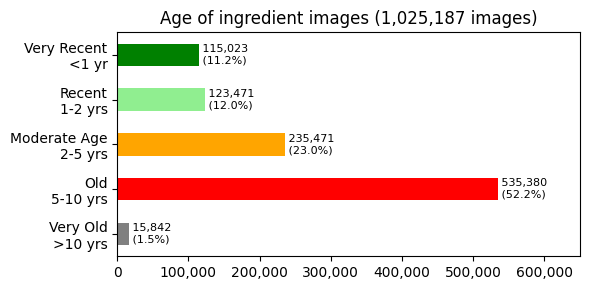

In [31]:
categories = ["<1 yr", "1-2 yrs", "2-5 yrs", "5-10 yrs", ">10 yrs"]
labels = ['Very Recent', 'Recent', 'Moderate Age', 'Old', 'Very Old']

def categorize_age(year: int):
    if year == 0:
        return categories[0]
    elif year == 1:
        return categories[1]
    elif year < 5:
        return categories[2]
    elif year < 10:
        return categories[3]
    else:
        return categories[4]

colors = ['green', 'lightgreen', 'orange', 'red', 'grey']

ax = df_year.map(categorize_age).value_counts().reindex(categories).plot.barh(figsize=(6,3), color=colors)

ax.yaxis.set_major_formatter(lambda x, pos: f"{labels[pos]}\n{categories[pos]}")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.invert_yaxis()
ax.set_xlim(0, 650000)
ax.set_ylabel(None)

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height() / 2,
            f' {width:,}\n ({width / len(df_year) * 100:.1f}%)', va='center', ha='left', fontsize=8)

plt.title(f"Age of ingredient images ({len(df_year):,} images)")
plt.tight_layout()
plt.savefig("freshness_rating_images.png");

In [32]:
# complicated stuff to make df_new and df_cat same length before concat
df_img_not_none = df_images.images.map(lambda x: {k:x[k] for k in x.keys() if x[k]['uploader'] is not None and x[k]['uploaded_t'] is not None}).rename('img')
df_new = pd.concat([df_images, df_img_not_none], axis=1)[lambda x: x.ingredients_percent_analysis.notna() & (x.img.map(len) > 0)]
df_cat = df_new.img.map(lambda x: [pd.to_datetime(x[k]['uploaded_t'], unit='s') for k in x.keys()])\
  .map(lambda x: relativedelta(pd.Timestamp.today(), x[-1]).years)\
  .map(categorize_age).to_frame('category')

/var/folders/yz/vvwzcc9178l36z8l4fc42bkm0000gn/T/ipykernel_23146/1774675239.py:4: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_cat = df_new.img.map(lambda x: [pd.to_datetime(x[k]['uploaded_t'], unit='s') for k in x.keys()])\


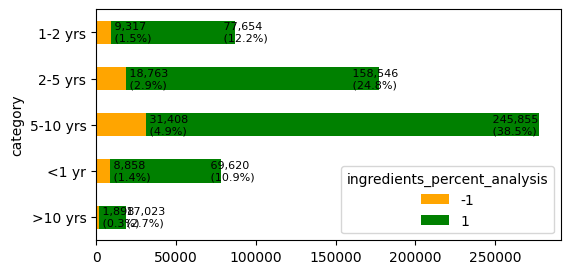

In [33]:
df_merged = pd.concat([df_cat, df_new.ingredients_percent_analysis], axis=1)
df_grouped = df_merged.groupby(['category', 'ingredients_percent_analysis']).size().unstack().astype(int)
ax = df_grouped.plot.barh(stacked=True, figsize=(6, 3), color=['orange', 'green'])
ax.invert_yaxis()

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height() / 2,
            f' {int(width):,}\n ({width / len(df_merged) * 100:.1f}%)', va='center', ha='left', fontsize=8)

In [34]:
df_grouped

ingredients_percent_analysis,-1,1
category,,
1-2 yrs,9317,77654
2-5 yrs,18763,158546
5-10 yrs,31408,245855
<1 yr,8858,69620
>10 yrs,1898,17023


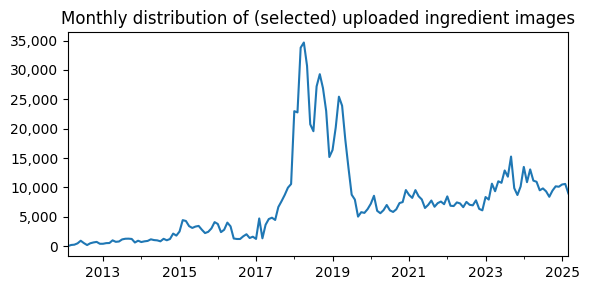

In [35]:
# aggregate by month
df_uploaded_month = df_dates.explode().dt.to_period('M')
ax = df_uploaded_month.value_counts().sort_index().plot(figsize=(6,3), title='Monthly distribution of (selected) uploaded ingredient images')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))
plt.xlabel(None)
plt.tight_layout()
plt.show()

## Ingredient Percent Analysis

In [36]:
df_analysis = df_images[lambda x: x.ingredients_percent_analysis.notna()]
print(f"{len(df_analysis):,}")
df_analysis.ingredients_percent_analysis.value_counts()#  / len(df_images) * 100

639,133


ingredients_percent_analysis
1     568873
-1     70260
Name: count, dtype: Int64

In [37]:
df_images.quality_info.str.contains('en:ingredients-percent-analysis-ok').sum()

568282